## Changing training paradigm to create a velocity corrector

In [2]:
# How they are created from high-fidelity data:
    # before:
        # X_train: mean pooling, then Nearest Neighbours interpolation
        # Y_train: n/a
    # now: 
        # X_train: mean pooling
        # Y_train: sampling (reduces size to network input size)

In [3]:
#imports
import jax
import jax.numpy as jnp

from jax_cfd.ml import towers
import jax_cfd.ml.train_utils as train_utils

import haiku as hk
import numpy as np
import xarray
import random

import pickle
from diego_model_utils import SaveObject, forward_pass_module
from diego_preprocessing import *
from diego_train_functions import *

import matplotlib.pyplot as plt
import seaborn

import time

In [4]:
# import data
file_name = '256x64_150_seconds_inner_1'
data = xarray.open_dataset(f'../../creating_dataset/datasets/'+ file_name +'.nc', chunks={'time': '100MB'})

In [5]:
# split by timestamps
x_shape = len(data.x)
y_shape = len(data.y)
high_def = []
for i in range(int(len(data.time))):
    this_time = jnp.dstack([
        jnp.array([data.u.isel(time = i)]).reshape(x_shape, y_shape),
        jnp.array([data.v.isel(time = i)]).reshape(x_shape, y_shape)
    ])
    high_def.append(this_time)

In [6]:
#warm up time (may want to discard initial stages of simulation since not really representative of turbulent flow?)
dt = float(data.time[0].values)

outer_steps = len(data.time.values)

inner_steps = (data.time[1].values-data.time[0].values)/dt

total_sim_time = outer_steps*inner_steps*dt
print("dt: \t\t" + str(dt))
print("outer_steps: \t" + str(outer_steps))
print("inner_steps: \t" + str(inner_steps))
print("total_sim_time: " + str(total_sim_time))

warm_up = 15 #seconds
warm_index = int(warm_up/total_sim_time * outer_steps // 1)
print("removed points: " + str(warm_index))
high_def = high_def[warm_index:]

print("\n")
step = 20
high_def = high_def[0::step]
print("step = " + str(step))
print("Training dataset shape: ") # (frames, x, y, input channels)
print("\t" + str(np.shape(high_def)))

dt: 		0.015625
outer_steps: 	9600
inner_steps: 	1.0
total_sim_time: 150.0
removed points: 960


step = 20
Training dataset shape: 
	(432, 256, 64, 2)


In [7]:
high_def_norm,ogMean,ogStdDev = normalisingDataset(high_def)

In [8]:
#split into train and test

split = 0.8
split = int(len(high_def)*split//1)
random.shuffle(high_def)

factor = 4


%time X_dataset = creatingDataset(high_def_norm,mean_pooling,factor)
%time Y_dataset = creatingDataset(high_def_norm,sampling,factor)

%time Y_dataset = calculateResiduals(X_dataset,Y_dataset)


X_train = X_dataset[:split]
Y_train = Y_dataset[:split]

X_test = X_dataset[split:]
Y_test = Y_dataset[split:]

CPU times: user 10.2 s, sys: 14.5 ms, total: 10.2 s
Wall time: 10.2 s
CPU times: user 901 ms, sys: 3.84 ms, total: 905 ms
Wall time: 908 ms
CPU times: user 15.1 ms, sys: 2 ms, total: 17.1 ms
Wall time: 17.4 ms


In [9]:
printAllShapes(X_train,Y_train, X_test,Y_test)

(345, 64, 16, 2)
(345, 64, 16, 2)
(87, 64, 16, 2)
(87, 64, 16, 2)


## Defining model shape

In [10]:
tower_module = towers.forward_tower_factory #add scaling here

In [11]:
num_output_channels = 2
# spatial_size = 17
ndim = 2
input_channels = 2

rng_key = jax.random.PRNGKey(42)


forward_pass = forward_pass_module(num_output_channels = num_output_channels, 
                                    ndim = ndim,
                                    tower_module = tower_module)
                                

forward_pass = hk.without_apply_rng(hk.transform(forward_pass))

## Training model

In [12]:
epochs = 200
learning_rates = staggeredLearningRate((50,0.1),(70,0.01),(50,0.005),(50,0.001))
printEvery=50
%time losses,val_losses,params = train(X_train,Y_train,X_test,Y_test,rng_key,input_channels,epochs,printEvery=printEvery,learning_rates=learning_rates,params=None,forward_pass=forward_pass,tol = 1e-10)

Shapes of all datasets
(345, 64, 16, 2)
(345, 64, 16, 2)
(87, 64, 16, 2)
(87, 64, 16, 2)


Epoch 50/200
	mse : 0.012318		val mse : 0.012327	Estimated end time: 23:11:27


Epoch 100/200
	mse : 0.011866		val mse : 0.011876	Estimated end time: 23:11:26


Epoch 150/200
	mse : 0.011628		val mse : 0.011640	Estimated end time: 23:11:24


Epoch 200/200
	mse : 0.011544		val mse : 0.011556	Estimated end time: 23:11:23



Finished training at max epochs

CPU times: user 31min 39s, sys: 26 s, total: 32min 5s
Wall time: 25min 59s


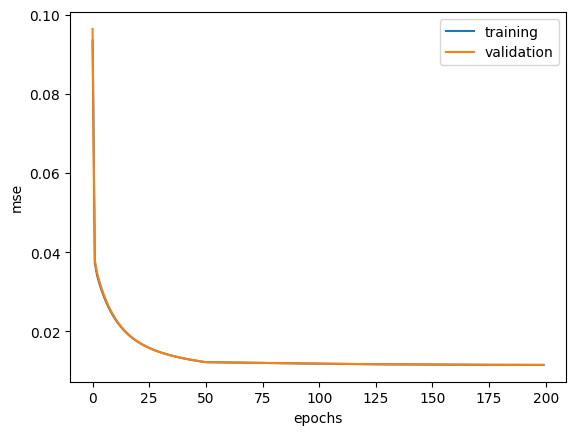

In [14]:
step = 1

plt.plot(losses[::step], label="training")
plt.plot(val_losses[::step],label="validation")
plt.ylabel("mse")
plt.xlabel("epochs")
# plt.yscale("log")
plt.legend()

## Saving model

In [15]:
toSave = SaveObject()
toSave.save_params(params)
toSave.save_forward_pass_params(num_output_channels,ndim,tower_module)

In [16]:
save_path = "./../models/velocity_correctors/first_normalised_model.pickle"

In [17]:
with open(save_path,"wb") as f:
    pickle.dump(toSave,f)

## Loading model

In [101]:
with open(save_path,'rb',) as pickle_file:
    loaded = pickle.load(pickle_file)
    loaded.make_forward_pass()
    loaded.preprocess()

## Predicting with loaded model

In [102]:
num =  19 #int(np.random.rand()*np.shape(X_test)[0]//1)
vel = 0      # 0 is u, 1 is v


scaledInput,xMean,xStdDev = normalisingDataset([X_test[num]])
scaledInput = scaledInput[0]

scaledTarget = (Y_test[num]-xMean)/xStdDev
scaledTarget = scaledTarget


In [103]:
pred = loaded.forward_pass.apply(loaded.params,scaledInput)

In [104]:
def vorticity(u,v):
    #dvdx - dudy
    return np.gradient(v,axis = 0) -np.gradient(u,axis = 1)

In [105]:
np.shape(pred)

(64, 16, 2)

In [106]:
vel = 1 #0 = u, 1 = v


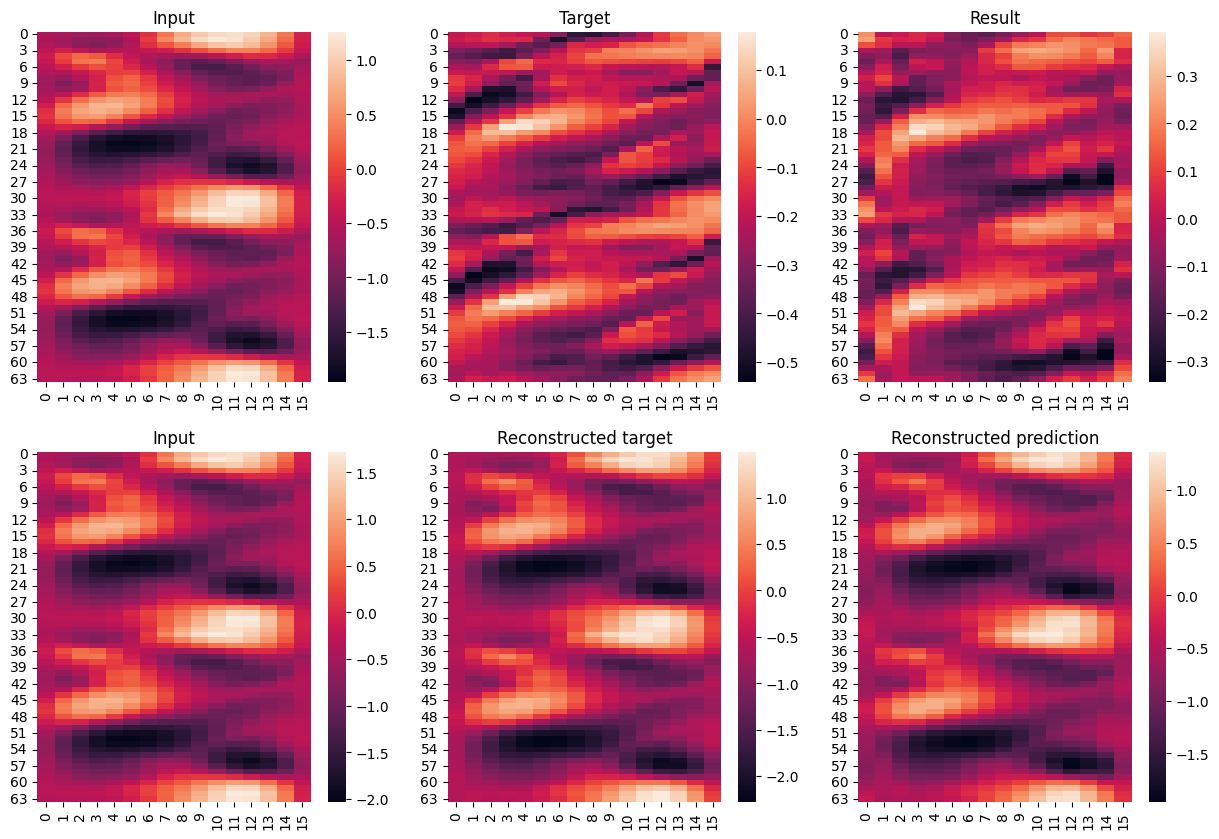

In [120]:
fig, axs = plt.subplots(2,3, facecolor='w', edgecolor='k',figsize=(15,10))
# fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()

im = seaborn.heatmap(scaledInput[:,:,vel],ax = axs[0])
axs[0].title.set_text("Input")
im = seaborn.heatmap(scaledTarget[:,:,vel],ax = axs[1])
axs[1].title.set_text("Target")
im = seaborn.heatmap(pred[:,:,vel],ax = axs[2])
axs[2].title.set_text("Result")



recPred = scaledInput[:,:,vel]+pred[:,:,vel]
redPred = (recPred*xStdDev)+xMean

recTarget = scaledTarget[:,:,vel]+scaledInput[:,:,vel]
recTarget = (recTarget*xStdDev)+xMean

recInput = (scaledInput[:,:,vel]*xStdDev)+xMean

im = seaborn.heatmap(recInput,ax = axs[3])
axs[3].title.set_text("Input")
im = seaborn.heatmap(recTarget,ax = axs[4])
axs[4].title.set_text("Reconstructed target")
im = seaborn.heatmap(recPred,ax = axs[5])
axs[5].title.set_text("Reconstructed prediction")

In [108]:
ogStdDev

0.21571971

In [109]:
target = Y_test[num][:,:,vel]
prediction = pred[:,:,vel]
np.mean(percentageError(target,prediction))

DeviceArray(0.19293654, dtype=float32)

In [34]:
rec_pred = X_test[num][:,:,vel]+pred[:,:,vel]
inp = X_test[num][:,:,vel]

mse(inp,rec_pred)

DeviceArray(0.01865573, dtype=float32)

In [122]:
#err_before = mse(X_test[num][:,:,vel],Y_test[num][:,:,vel]+X_test[num][:,:,vel])
#err_after = mse(rec_pred,inp)

err_before = mse(recInput,recTarget)
err_after = mse(recPred,recTarget)

print("Error before correction: " + str(err_before))
print("Error after correction: " + str(err_after))

if err_after<err_before:
    print("Error reduced by network, nice")
else:
    print("WARNING: error increased by network")

Error before correction: 0.089499146
Error after correction: 0.026235722
Error reduced by network, nice
